In [39]:
import random
import numpy as np

DATA = np.genfromtxt('Paridad.csv', delimiter=',')

class Node:
    def __init__(self, valor):
        self.valor = valor
        self.hijos = []

    def agregar_hijo(self, hijo):
        self.hijos.append(hijo)

def and_func(x, y):
    return x and y

def or_func(x, y):
    return x or y

def not_func(x):
    return not x

def nor_func(x, y):
    return not (x or y)

def crear_arbol(profundidad):
    if profundidad <= 0 or random.random() < 0.1:
        return Node(random.choice(['A', 'B', 'C']))
    else:
        operador = random.choice(['AND', 'OR', 'NOT', 'NOR'])
        node = Node(operador)
        for _ in range(2 if operador in ['AND', 'OR', 'NOR'] else 1):
            node.hijos.append(crear_arbol(profundidad - 1))
        return node

def imprimir_arbol(arbol, nivel=0):
    if arbol is not None:
        print('-' * nivel + arbol.valor)
        for hijo in arbol.hijos:
            imprimir_arbol(hijo, nivel + 2)

def calcular_profundidades(nodo):
    if nodo.hijos == []:
        return 1
    else:
        return 1 + max([calcular_profundidades(hijo) for hijo in nodo.hijos])

def evaluar_arbol(arbol, a, b, c):
    # funcion recursiva que evalua el arbol, solo evalua para 1 renglon de la tabla de verdad
    if arbol.valor == 'A':
        return a
    elif arbol.valor == 'B':
        return b
    elif arbol.valor == 'C':
        return c
    elif arbol.valor == 'AND':
        return and_func(evaluar_arbol(arbol.hijos[0], a, b, c), evaluar_arbol(arbol.hijos[1], a, b, c))
    elif arbol.valor == 'OR':
        return or_func(evaluar_arbol(arbol.hijos[0], a, b, c), evaluar_arbol(arbol.hijos[1], a, b, c))
    elif arbol.valor == 'NOT':
        return not_func(evaluar_arbol(arbol.hijos[0], a, b, c))
    elif arbol.valor == 'NOR':
        return nor_func(evaluar_arbol(arbol.hijos[0], a, b, c), evaluar_arbol(arbol.hijos[1], a, b, c))
    else:
        pass
    
def evaluar_arbol_completo(arbol):
    # funcion que evalua el arbol para todas las combinaciones de la tabla de verdad
    correctas = 0
    incorrectas = 0
    for i in DATA:
        prediccion = evaluar_arbol(arbol, i[0], i[1], i[2])
        # print("Prediccion: ", prediccion)
        # print("Respuesta esperada: ", i[3])
        if prediccion == i[3]:
            correctas += 1
        else:
            incorrectas += 1
    fitness = correctas/(correctas+incorrectas)
    # print("Correctas: ", correctas)
    # print("Incorrectas: ", incorrectas)
    # print("Porcentaje de acierto: ",fitness)
    return fitness

def mutacion(arbol, prob=0.1):
    # funcion que muta un arbol/individuo
    if random.random() < prob:
        prob = 0
        return crear_arbol(MAX_profundidad)
    else:
        nuevo_arbol = Node(arbol.valor)
        for hijo in arbol.hijos:
            nuevo_arbol.hijos.append(mutacion(hijo))
        return nuevo_arbol

def cruzamiento(arbol1, arbol2, prob = 0.8):
    if random.random() > prob:
        return arbol2, arbol1
    else:
        nodos_a1 = num_nodos(arbol1)
        nodos_a2 = num_nodos(arbol2)
        subarbol1 = encontrar_subarbol(arbol1)
        subarbol2 = encontrar_subarbol(arbol2)
        hijo1 = insertar_subarbol(arbol1, subarbol2, nodos_a1)
        hijo2 = insertar_subarbol(arbol2, subarbol1, nodos_a2)
        return hijo1, hijo2
    
def obtener_nodos(raiz):
    if not raiz:
        return []
    lista_nodos = []
    stack = [raiz]
    while stack:
        nodo = stack.pop()
        lista_nodos.append(nodo)
        stack.extend(nodo.hijos)
    return lista_nodos

def encontrar_subarbol(raiz):
    if not raiz:
        return None
    lista_nodo = obtener_nodos(raiz)
    random_node = random.choice(lista_nodo)
    return crear_arbol_rec(random_node)

def crear_arbol_rec(arbol):
    if not arbol:
        return None
    raiz_subarbol = Node(arbol.valor)
    for hijo in arbol.hijos:
        subarbol_hijo = crear_arbol_rec(hijo)
        raiz_subarbol.agregar_hijo(subarbol_hijo)
    return raiz_subarbol

  
def insertar_subarbol(arbol, subarbol, num_nodos):
    prob = 3/num_nodos
    if arbol.hijos == []:
        return subarbol
    else:
        for i, hijo in enumerate(arbol.hijos):
            if random.random() < prob:
                arbol.hijos[i] = subarbol
                return arbol
            else:
                return insertar_subarbol(hijo, subarbol, num_nodos-1)

def num_nodos(arbol):
    if arbol.hijos == []:
        return 1
    else:
        return 1 + sum([num_nodos(hijo) for hijo in arbol.hijos])


In [40]:
def seleccionar_padres_ruleta(fitness):
    # seleccionar padres con probabilidad proporcional al fitness
    suma_fitness = sum(fitness)
    probabilidad = [fit/suma_fitness for fit in fitness]
    padres = []
    for _ in range(2):
        r = random.random()
        acumulado = 0
        for i, prob in enumerate(probabilidad):
            acumulado += prob
            if r < acumulado:
                padres.append(i)
                break
    return padres


def correr_algoritmo(generaciones, max_profundidad, poblacion=100):
    fitness_por_generacion = []
    fitness_promedio_generacion = []
    # crear poblacion inicial
    poblacion = [crear_arbol(max_profundidad) for _ in range(poblacion)]
    # evaluar poblacion
    fitness = [evaluar_arbol_completo(individual) for individual in poblacion]
    for generacion in range(generaciones):
        print('Generacion', generacion)
        # seleccionar padres
        padres = seleccionar_padres_ruleta(fitness)
        # cruzamiento
        hijos = []
        for i in range(0, len(poblacion), 2):
            hijo1, hijo2 = cruzamiento(poblacion[padres[0]], poblacion[padres[1]])
            hijos.append(hijo1)
            hijos.append(hijo2)
        # mutacion
        hijos = [mutacion(hijo) for hijo in hijos]
        # evaluar hijos
        fitness_hijos = [evaluar_arbol_completo(individual) for individual in hijos]
        # seleccionar sobrevivientes
        poblacion = hijos
        fitness = fitness_hijos
        fitness_por_generacion.append(max(fitness))
        fitness_promedio_generacion.append(np.mean(fitness))
    return fitness_por_generacion, fitness_promedio_generacion




In [41]:
MAX_profundidad = 5
fitness_gen, fitness_avg = correr_algoritmo(1000, MAX_profundidad)

Generacion 0
Generacion 1
Generacion 2
Generacion 3
Generacion 4
Generacion 5
Generacion 6
Generacion 7
Generacion 8
Generacion 9
Generacion 10
Generacion 11
Generacion 12
Generacion 13
Generacion 14
Generacion 15
Generacion 16
Generacion 17
Generacion 18
Generacion 19
Generacion 20
Generacion 21
Generacion 22
Generacion 23
Generacion 24
Generacion 25
Generacion 26
Generacion 27
Generacion 28
Generacion 29
Generacion 30
Generacion 31
Generacion 32
Generacion 33
Generacion 34
Generacion 35
Generacion 36
Generacion 37
Generacion 38
Generacion 39
Generacion 40
Generacion 41
Generacion 42
Generacion 43
Generacion 44
Generacion 45
Generacion 46
Generacion 47
Generacion 48
Generacion 49
Generacion 50
Generacion 51
Generacion 52
Generacion 53
Generacion 54
Generacion 55
Generacion 56
Generacion 57
Generacion 58
Generacion 59
Generacion 60
Generacion 61
Generacion 62
Generacion 63
Generacion 64
Generacion 65
Generacion 66
Generacion 67
Generacion 68
Generacion 69
Generacion 70
Generacion 71
Ge

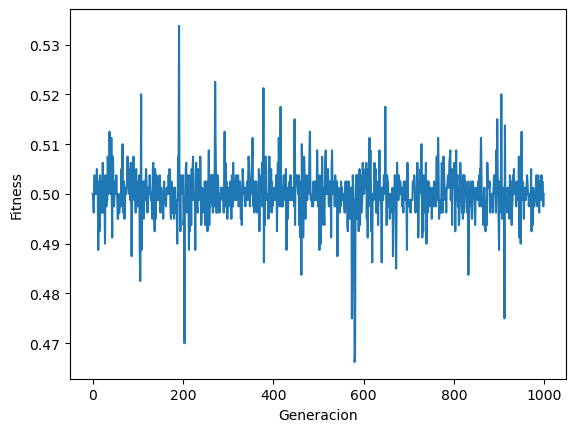

In [42]:
import matplotlib.pyplot as plt
plt.plot(fitness_avg)
plt.xlabel('Generacion')
plt.ylabel('Fitness')
plt.show()

In [46]:
# ejemplos de programacion genética!!!

# Definir conjuntos: 1 funciones 2 terminales 3 aridad (asociada a 1)
# restringir el tamaño

import numpy as np

def suma(x, y):
    """
    """
    return x + y

def resta(x, y):
    """
    """
    return x-y

def multi(x, y):
    """
    """
    return x*y

def divi(x, y):
    """
    """
    if np.any(y == 0):
        raise Exception
    return x/y

def invi(x):
    """
    """
    return 1/x

x = np.array([1,2,3])
y = np.array([4,5,6])
z = np.array([7,8,9])

functions = {'+': suma,
             '-': resta,
             '*': multi,
             '%': divi,
             '_': invi}

arities = {'+': 2,
           '-': 2,
           '*': 2,
           '%': 2,
           '_': 1}


v = [x, y, z]

# individuo (x + y) * z
ind = ['*', '+', 0, 1, 2]

# 1+1+1+1+1+1+1+1+1+1
ind1 = list('+++++++++1111111111')
ind1 = ['+']*30 + [1]*31

def parse(tokens):
    token = tokens.pop()
    if token in functions:
        return functions[token](parse(tokens), parse(tokens))
    else:
        return v[token]



# https://stackoverflow.com/questions/5307218/prefix-notation-parsing-in-python
def parse(tokens):
    token=tokens.popleft()
    if token=='+':
            return parse(tokens)+parse(tokens)
    elif token=='-':
            return parse(tokens)-parse(tokens)
    elif token=='*':
            return parse(tokens)*parse(tokens)
    elif token=='/':
            return parse(tokens)/parse(tokens)
    else:
            # must be just a number
            return int(token)

In [52]:
a = [1,2,3,4]
a.popleft()

AttributeError: 'list' object has no attribute 'popleft'

In [51]:
a

[1, 2, 3]

In [49]:
ind1 = list('+++++++++1111111111')


ModuleNotFoundError: No module named 'deque'

In [44]:
ind1

['+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [53]:
expression = ["+", "*", 1, 2, 3]

# Find the multiplication operator ('*') in the list
operator_index = expression.index("*")

# Numbers being multiplied are the ones immediately following the operator
operands = expression[operator_index + 1 : operator_index + 3]

print("Operands being multiplied:", operands)

Operands being multiplied: [1, 2]


In [75]:
from collections import deque
def parse(tokens):
    token=tokens.popleft()
    if token=='+':
            return parse(tokens)+parse(tokens)
    elif token=='-':
            return parse(tokens)-parse(tokens)
    elif token=='*':
            return parse(tokens)*parse(tokens)
    elif token=='/':
            return parse(tokens)/parse(tokens)
    elif token=='abs':
            return abs(parse(tokens))
    else:
            # must be just a number
            return int(token)



expression="+ * - 2 1 3 4"
print(parse(deque(expression.split())))

7


In [64]:
a = deque(expression.split())

Original Expression: + * 2 2 3


TypeError: sequence index must be integer, not 'slice'

In [98]:
import random
from collections import deque

def parse(tokens):
    token = tokens.popleft()
    if token == '+':
        return parse(tokens) + parse(tokens)
    elif token == '-':
        return parse(tokens) - parse(tokens)
    elif token == '*':
        return parse(tokens) * parse(tokens)
    elif token == '/':
        return parse(tokens) / parse(tokens)
    elif token == 'abs':
        return abs(parse(tokens))
    else:
        # must be just a number
        return int(token)

def remove_operation_from_polish_notation(tokens, operation_index):
    """
    """
    tokens = deque(tokens)
    tokens = list(tokens)
    operator_index = tokens.index(operation_index)
    operands = tokens[operator_index + 1: operator_index + arities[operation_index] + 1]
    tokens = tokens[:operator_index] + operands + tokens[operator_index + arities[operation_index] + 1:]
    return tokens

resultad = remove_operation_from_polish_notation(ind, 1)


KeyError: 1

In [82]:
a = [1,2,3,4,5,6,7,8,9,10]
del a[2:4]

In [83]:
a

[1, 2, 5, 6, 7, 8, 9, 10]